# Rasterise the plans

In [16]:
import os
import pprint

import cv2
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import shapely
from affine import Affine
from PIL import Image
from rasterio import features
from pathlib import Path


In [4]:
# Load the python file

with rasterio.open("python_logo.png") as src:
    blue = src.read(3)

# pprint requires that the image dtype must be one of: int16, int32, uint8, uint16, float32.
# If your data comes as int8 you can cast your data to an appropriate dtype like this:
# data = data.astype('int16')

mask = blue != 255
shapes = features.shapes(blue, mask=mask)
pprint.pprint(next(shapes))

({'coordinates': [[(71.0, 6.0),
                   (71.0, 7.0),
                   (72.0, 7.0),
                   (72.0, 6.0),
                   (71.0, 6.0)]],
  'type': 'Polygon'},
 253.0)


/Users/tristanwaddington/anaconda3/envs/contour/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


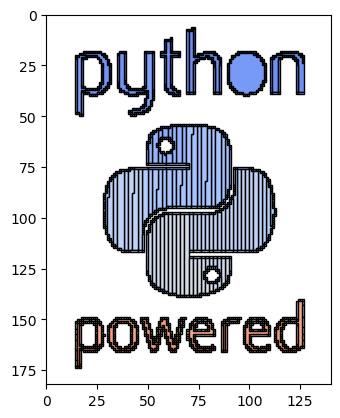

1580 features detected.


In [5]:
# Plot the detected features
fig, ax = plt.subplots()

# Generate a gradient of colors using a diverging colormap
cmap = plt.get_cmap("coolwarm")
norm = plt.Normalize(vmin=0, vmax=2000)
colors = [cmap(norm(i)) for i in range(2000)]

# Reset the shapes generator
shapes = features.shapes(blue, mask=mask)
count = 0
for shape, color in zip(shapes, colors):
    geom = shape[0]
    ax.add_patch(
        plt.Polygon(
            geom["coordinates"][0],
            closed=True,
            edgecolor="black",
            facecolor=color,
        )
    )
    count += 1

ax.set_xlim(0, blue.shape[1])
ax.set_ylim(0, blue.shape[0])
ax.set_aspect("equal")
plt.gca().invert_yaxis()
plt.show()
print(f"{count} features detected.")

In [6]:
with rasterio.open("python_logo.png") as src:
    print(src)

<open DatasetReader name='python_logo.png' mode='r'>


/Users/tristanwaddington/anaconda3/envs/contour/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [39]:
def vectorization(
    input_path, output_path, filename, extension, bbox_on=False, min_area=20
):
    """
    [modified https://github.com/LymanSong/FP_GNN/blob/main/vectorize.py]
    # Parameters: input_path, output_path, filename, extension, bbox_on = False, min_area = 5
    - input_path: A directory where the image to be vectorized is located
    - output_path: A directory to store pre-processed image and output polygon files
    - filename: The name of the target image without extension
    - extension: which extension the targe image use
    - bbox_on: get the bounding box of the input image (default: False)
    - min_area: a threshold parameter to remove small polygons
    
    # Usage
    Input the location and name of the target image to open and vectorize by using Rasterio lib.
    This function has several steps inbetween, like bufferizing polygons, filling the bubbles \
    (inner holes in/ or between polygons) by making them into polygon.
    
    # output
    A geodataframe extracted from the image
    """

    # os.chdir(input_path)
    input_file = Path(input_path, filename + extension)
    img = cv2.imread(input_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, cur_bin_img = cv2.threshold(
        gray, 235, 255, cv2.THRESH_BINARY
    )  # binarization

    if bbox_on:
        # get the bounding box of image and split
        img = Image.fromarray(cur_bin_img)
        l, u, r, d = img.getbbox()  # bbox of input image
        cur_bin_img = cur_bin_img[:d, :r]
        cur_bin_img = cur_bin_img[u:, l:]
        cur_bin_img = np.pad(
            cur_bin_img, pad_width=(4), mode="constant", constant_values=255
        )
    # os.chdir(output_path)
    output_path = Path(output_path, filename)
    output_path.mkdir(parents=True, exist_ok=True)
    processed_image_filename = "bin_" + filename + extension
    cv2.imwrite(
        output_path / processed_image_filename, cur_bin_img
    )  # save processed image

    # get vectorized shapes using rasterio
    image = cur_bin_img
    aff = Affine(1, 0, 1, 0, -1, 0)  # Adjust flip and symmetry
    mask = image == 255

    shapes = features.shapes(image, mask=mask, transform=aff)
    results = (
        {"properties": {"raster_val": i}, "geometry": s}
        for i, (s, v) in enumerate(shapes)
    )

    # save polygon in shape/GeoJSON format
    with fiona.open(
        Path(output_path, filename + "_polys.shp"),
        "w",
        driver="ESRI Shapefile",
        schema={"properties": [("raster_val", "int")], "geometry": "Polygon"},
    ) as dst:
        dst.writerecords(results)

    # buffered polygons(shapely)
    df = gpd.read_file(Path(output_path, filename + "_polys.shp"))
    df = df.buffer(1, 10, cap_style=2, join_style=2)

    # remove useless and small polygons whose area is less than threshold
    to_pop = [i for i in range(len(df)) if df.iloc[i].area < min_area]
    # to_pop.append(-1)

    df = df.drop(df.index[to_pop])
    df = df.reset_index(drop=True)


    # fill the black area in the image(refered as bubbles)
    uunion = df.unary_union
    canvas = shapely.geometry.box(
        uunion.bounds[0], uunion.bounds[1], uunion.bounds[2], uunion.bounds[3]
    )
    bubbles_ = canvas - uunion
    bubbles = []
    for i in bubbles_.geoms:
        if i.area > min_area:
            bubbles.append(i)

    if len(bubbles) > 0:
        # gpd.GeoSeries(bubbles).to_file(Path(output_path, "bubbles.shp"))
        df = pd.concat([df, gpd.GeoSeries(bubbles)], ignore_index=True)


    # export buffered polygon geodataframe and overwrite
    df2 = gpd.GeoDataFrame(
        {
            "obj_id": range(len(df)),
            "obj_class": np.zeros(len(df), np.int64),
            "geometry": df,
        }
    )  # initialize obj class features with 0s
    df2 = df2.reset_index()
    df2.to_file(Path(output_path, filename + "_polys.shp"))

    return df2

In [40]:
vectorization("data/images/", "data/vectorized", "output8", ".png")

/var/folders/vw/2kmjpl310zl2lwgnwpxsyw4r0000gn/T/ipykernel_5665/341472893.py:81: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  uunion = df.unary_union
/Users/tristanwaddington/anaconda3/envs/contour/lib/python3.13/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


,index,obj_id,obj_class,geometry
0,0,0,0,"POLYGON ((42 -26, 47 -26, 47 -34, 42 -34, 42 -..."
1,1,1,0,"POLYGON ((51 -26, 56 -26, 56 -34, 51 -34, 51 -..."
2,2,2,0,"POLYGON ((60 -26, 65 -26, 65 -34, 60 -34, 60 -..."
3,3,3,0,"POLYGON ((34 -26, 38 -26, 38 -27, 39 -27, 39 -..."
4,4,4,0,"POLYGON ((2092 -128, 2103 -128, 2103 -143, 209..."
...,...,...,...,...
244,244,244,0,"POLYGON ((1375 -1568, 1375 -1579, 1373 -1579, ..."
245,245,245,0,"POLYGON ((1220 -705, 1220 -707, 1174 -707, 117..."
246,246,246,0,"POLYGON ((1032 -428, 1032 -444, 1030 -444, 103..."
247,247,247,0,"POLYGON ((1068 -115, 1068 -127, 1067 -127, 106..."


In [43]:
img_path = Path("data", "images")
vect_path = Path("data", "vectorized")
for img_file in img_path.iterdir():
    out = vectorization(img_path, vect_path, img_file.stem, ".png")

/var/folders/vw/2kmjpl310zl2lwgnwpxsyw4r0000gn/T/ipykernel_5665/341472893.py:81: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  uunion = df.unary_union
/Users/tristanwaddington/anaconda3/envs/contour/lib/python3.13/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
/var/folders/vw/2kmjpl310zl2lwgnwpxsyw4r0000gn/T/ipykernel_5665/341472893.py:81: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  uunion = df.unary_union
/Users/tristanwaddington/anaconda3/envs/contour/lib/python3.13/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
/var/folders/vw/2kmjpl310zl2lwgnwpxsyw4r0000gn/T/ipykernel_5665/341472893.py

In [44]:
out

,index,obj_id,obj_class,geometry
0,0,0,0,"POLYGON ((42 -26, 47 -26, 47 -34, 42 -34, 42 -..."
1,1,1,0,"POLYGON ((51 -26, 56 -26, 56 -34, 51 -34, 51 -..."
2,2,2,0,"POLYGON ((60 -26, 65 -26, 65 -34, 60 -34, 60 -..."
3,3,3,0,"POLYGON ((34 -26, 38 -26, 38 -27, 39 -27, 39 -..."
4,4,4,0,"POLYGON ((2092 -128, 2103 -128, 2103 -143, 209..."
...,...,...,...,...
244,244,244,0,"POLYGON ((1375 -1568, 1375 -1579, 1373 -1579, ..."
245,245,245,0,"POLYGON ((1220 -705, 1220 -707, 1174 -707, 117..."
246,246,246,0,"POLYGON ((1032 -428, 1032 -444, 1030 -444, 103..."
247,247,247,0,"POLYGON ((1068 -115, 1068 -127, 1067 -127, 106..."


<Axes: >

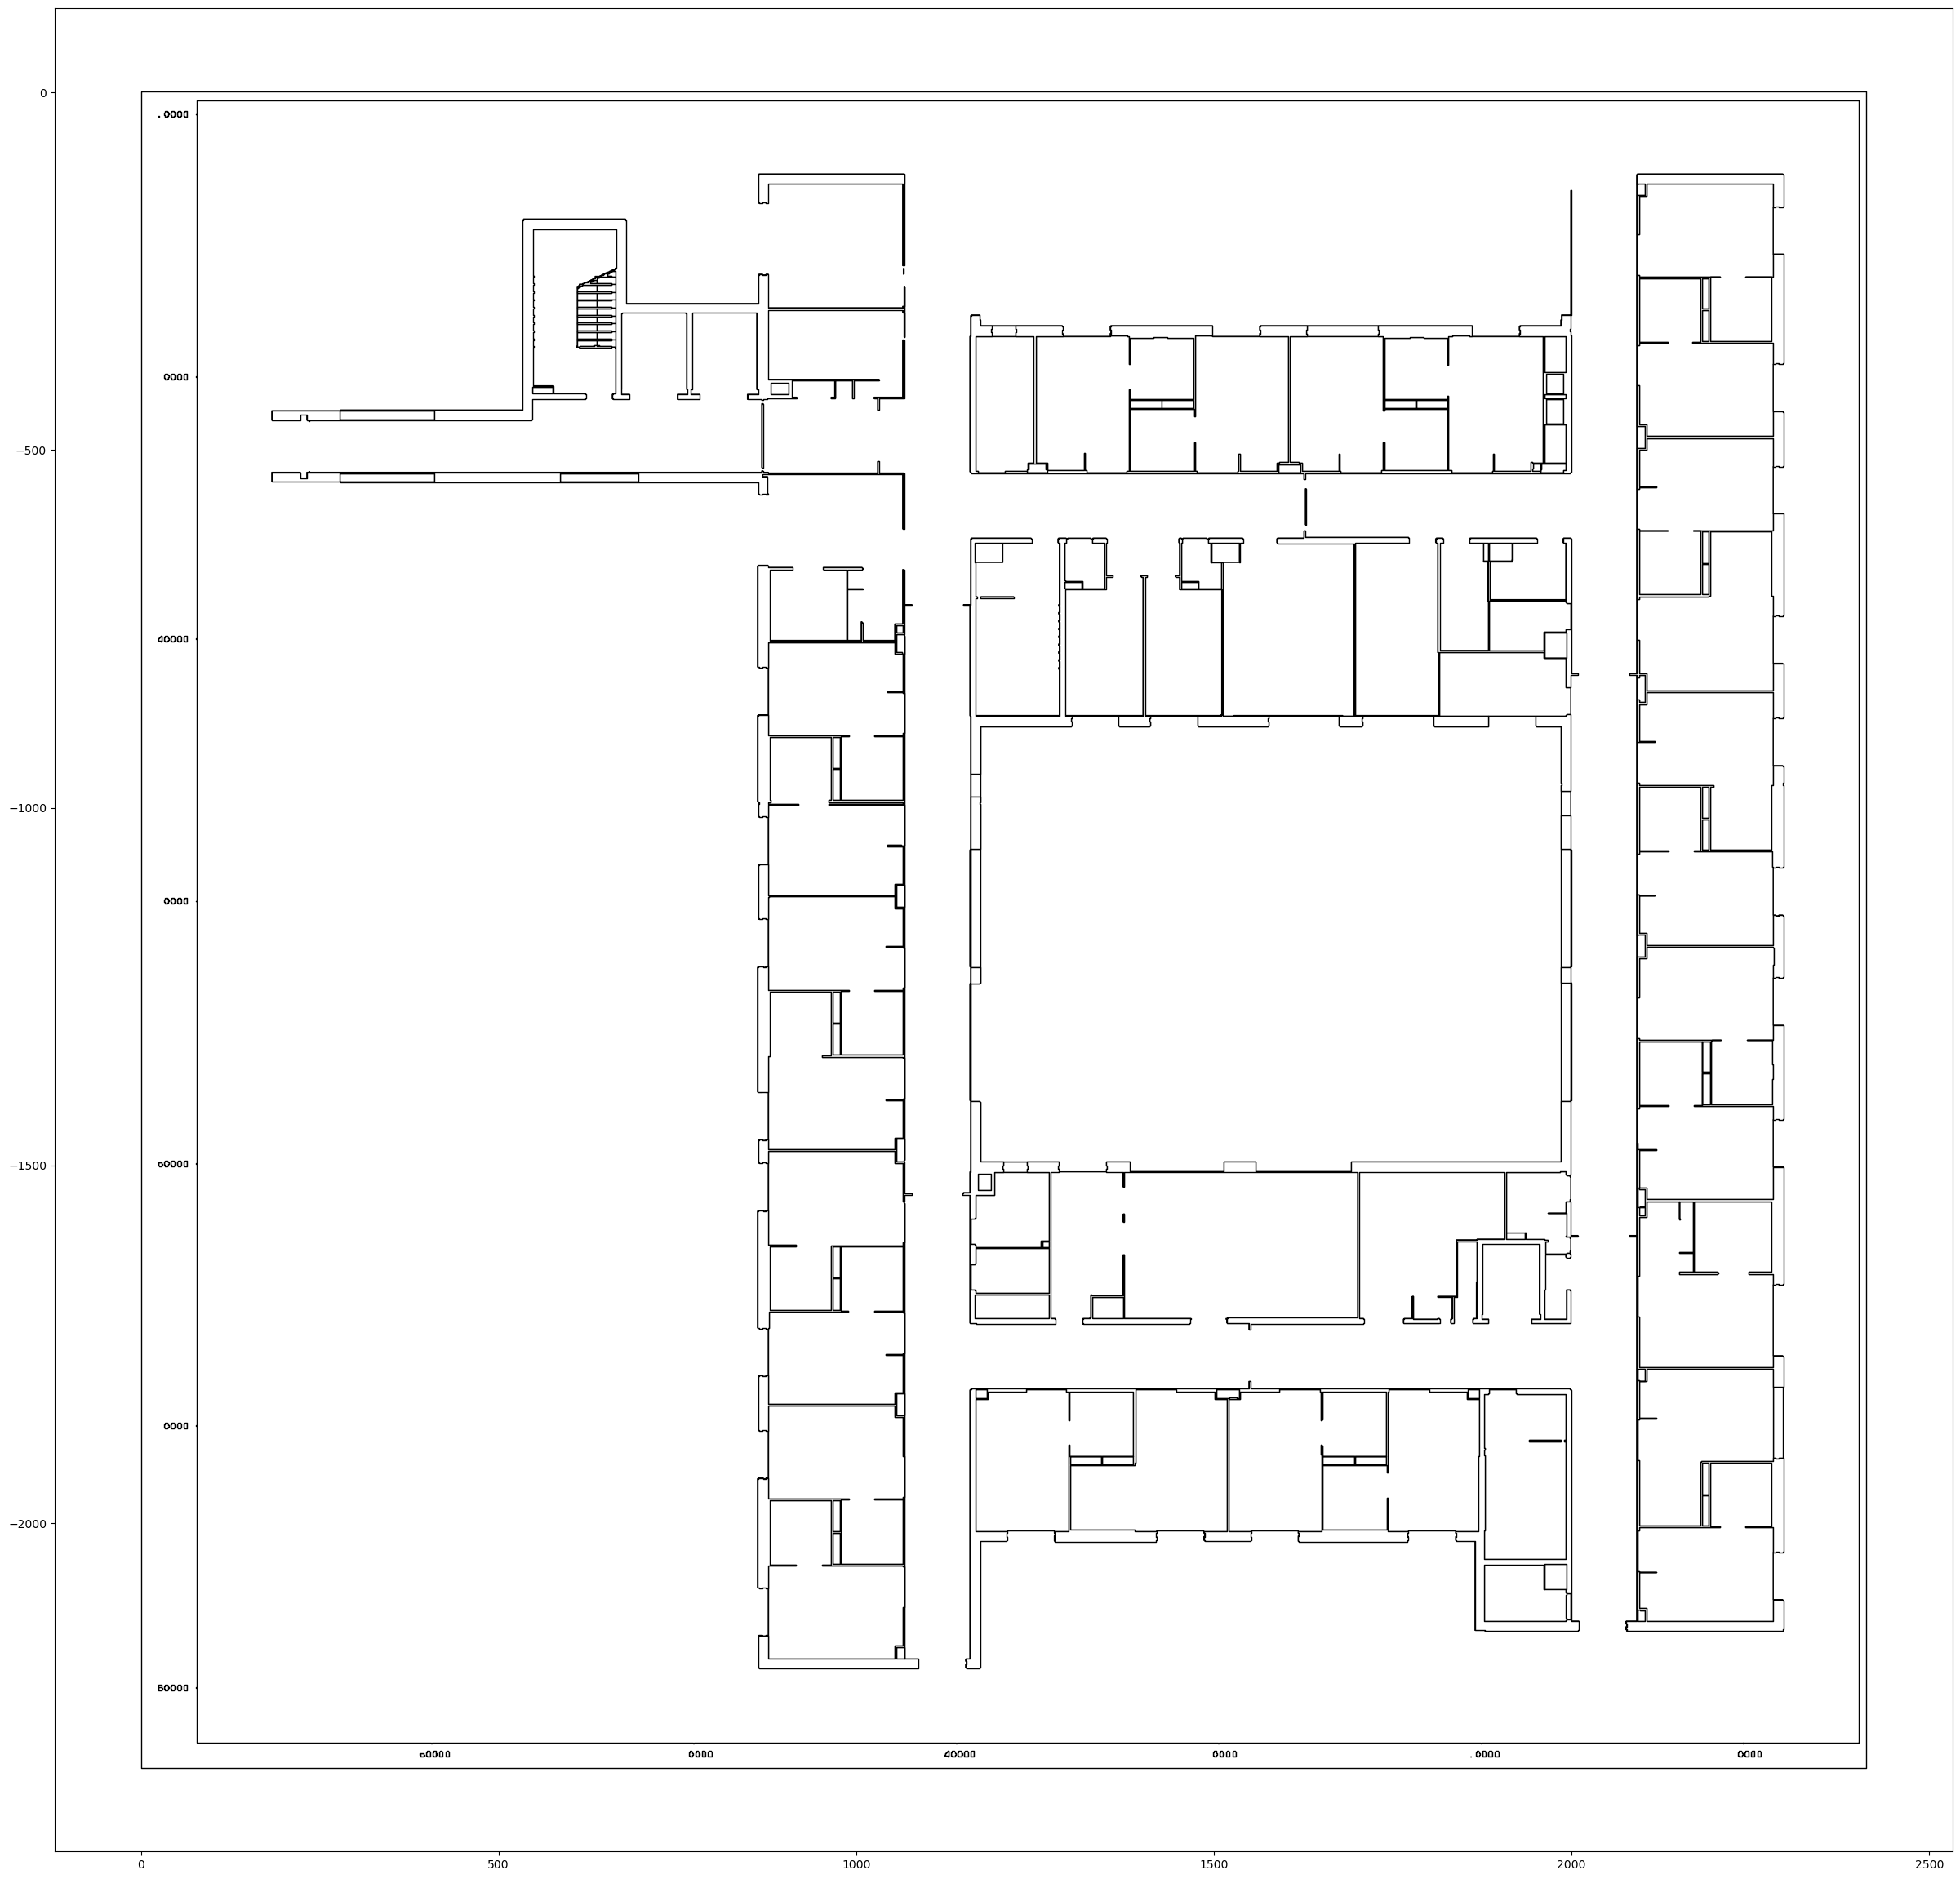

In [48]:
out.plot(edgecolor="k",facecolor ="w", figsize=(30,30))